# Churn de Clientes de um Banco

*Churn*, uma expressão que representa taxa de evasão de clientes. Em alguns serviços pode representar o cancelamento de uma assinatura em outros como o nosso caso representa um cliente que fechou sua conta no banco.

Manter clientes é tão importante quanto adquirir novos clientes, com isso por meio desse projeto irei analisar o que leva eles a fecharem sua conta no banco e prever quem pode sair. Assim trabalhando para tentar manter esses clientes com ações, promoções e etc.

## Ensemble de Modelos

O *Ensemble* em Machine Learning, é um método de agrupamento de algoritmos para que se obtenha o melhor desempenho.

## Dados

Os dados foram retirados do [Kaggle](https://www.kaggle.com) e tem a finalidade de estudo.

Segundo sua descrição: "Esse dataset contém detalhes de clientes de um banco e a variável alvo é binária refletindo qual cliente deixou o banco (fechou sua conta) ou continua como cliente."

O dataset completo pode ser encontrado neste [link](https://www.kaggle.com/shrutimechlearn/churn-modelling).

In [1]:
# Importanto bibliotecas
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier

# seed global
np.random.seed(42)

In [2]:
# importando o dataset
churn = pd.read_csv('Churn_Modelling.csv')

# primeiras linhas
churn.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


- **RowNumber:** Número das linhas de 1 até 10000;
- **CustomerId:** Id único para identificação de clientes;
- **Surname:** Ultimo nome do cliente;
- **CreditScore:** Score de crédito do cliente;
- **Geography:** O país de onde pertence do cliente;
- **Gender:** Masculino our feminino;
- **Age:** Idade do cliente;
- **Tenure:** Número de anos que o cliente está com o banco;
- **Balance:** Balanço bancário do cliente;
- **NumOfProducts:** Número de produtos do banco que o cliente está utilizando;
- **HasCrCard:** Classificação binária que mostra se o cliente tem um cartão de crédito com o banco ou não;
- **IsActiveMember:** Classificação binária que mostra se o cliente é um membra ativo do banvo ou não;
- **EstimatedSalary:** Sáralio estimado do cliente em Dolares;
- **Exited:** Classificação binária, 1 se o cliente fechou a conta com o banco e 0 se o cliente contínua;

# Análise Exploratória

O Dataset tem exatamente 10000 linhas e 14 colunas além de ser dividido em 80% dos clientes com conta aberta no banco e 20% fecharam sua conta. A divisão não é igual mas também não é tão baixa ao ponto de atrapalhar os modelos.

In [3]:
# tamanho do dataset
churn.shape

(10000, 14)

In [4]:
# porcentagem variavel alvo
churn.Exited.value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

Todas as colunas no formato certo.

In [5]:
# informações dos dados
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Nenhum valor faltante.

In [6]:
# valores faltantes
churn.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

No resumo estátistico, eu separei apenas as variáveis númericas. 

É possivel perceber algumas coisas, como:
- o *Score* médio é de 650, enquanto o minimo é 350 e o máximo é 850;
- A média de idade é de 38 anos, e vai de 18 a 92 anos;
- *Tenure* (anos que o cliente está com o banco), tem média de 5 anos mas tem um máximo de 10;
- *EstimatedSalary* (salário estimado), tem média de 10000;

In [7]:
# resumo estátistico
churn[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']].describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,100090.239881
std,96.653299,10.487806,2.892174,62397.405202,0.581654,57510.492818
min,350.000000,18.000000,0.000000,0.000000,1.000000,11.580000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,51002.110000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,100193.915000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,149388.247500
max,850.000000,92.000000,10.000000,250898.090000,4.000000,199992.480000


O número de homens é maior que o de mulheres mas neste dataset não se ve diferença significativa entre os dois em outras colunas como salário, idade ou *Score*.

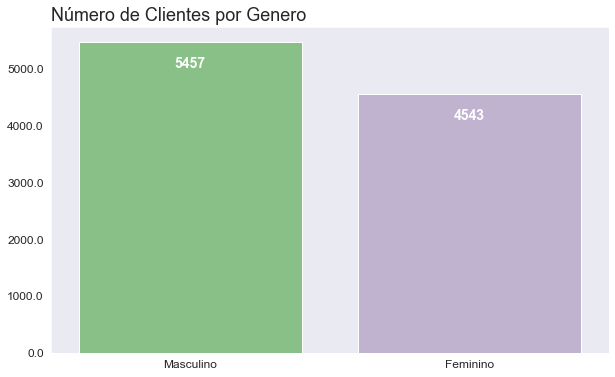

In [8]:
# estilo dos gráficos
sns.set_palette('Accent')
sns.set_style('dark')

# gráfico
plt.figure(figsize=(10, 6))
ax = sns.countplot(churn.Gender, order=churn.Gender.value_counts().index)
ax.set_title('Número de Clientes por Genero', fontsize=18, loc='left');
ax.set_xlabel('', fontsize=14)
ax.set_ylabel('', fontsize=14)
ax.set_xticklabels(['Masculino', 'Feminino'], fontsize=12);
ax.set_yticklabels(ax.get_yticks(), fontsize=12);

labels = (churn.Gender.value_counts())
for i, v in enumerate(labels):
    ax.text(i, v-450, str(v), horizontalalignment = 'center', size = 14, color = 'w', fontweight = 'bold')

In [9]:
# agrupamento por gênero
churn.groupby('Gender').median()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
Gender,,,,,,,,,,,
Female,4891,15691483,652,38,5,96147.55,1,1,1,101905.34,0
Male,5081,15690440,651,37,5,98064.97,1,1,1,98060.51,0


Nesse dataset mulheres foram as que mais fecharam as contas no banco.

In [10]:
# agrupamento por gênero e saída
churn.groupby('Gender')['Exited'].value_counts()

Gender  Exited
Female  0         3404
        1         1139
Male    0         4559
        1          898
Name: Exited, dtype: int64

Os clientes são em sua maioria da França, Alemanha e Espanha tem praticamente o mesmo número de clientes.

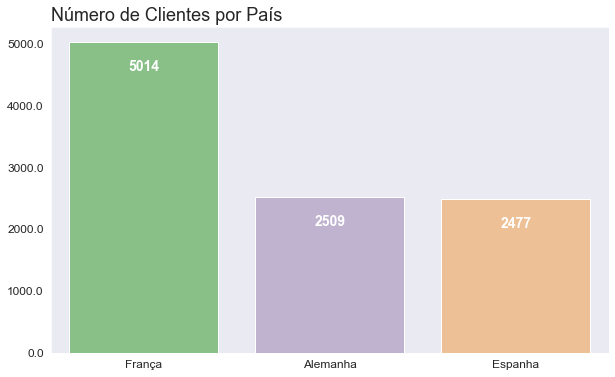

In [11]:
# gráfico
plt.figure(figsize=(10, 6))
ax = sns.countplot(churn.Geography, order=churn.Geography.value_counts().index)
ax.set_title('Número de Clientes por País', fontsize=18, loc='left');
ax.set_xlabel('', fontsize=14)
ax.set_ylabel('', fontsize=14)
ax.set_xticklabels(['França', 'Alemanha', 'Espanha'], fontsize=12);
ax.set_yticklabels(ax.get_yticks(), fontsize=12);

labels = (churn.Geography.value_counts())
for i, v in enumerate(labels):
    ax.text(i, v-450, str(v), horizontalalignment = 'center', size = 14, color = 'w', fontweight = 'bold')

Análisando pela saída de clientes por país, é possivel notar que clientes alemães tem maior porcentagem de fechamento de contas.

In [12]:
# agrupamento por saída de país
churn.groupby('Geography')['Exited'].value_counts(normalize=True)

Geography  Exited
France     0         0.838452
           1         0.161548
Germany    0         0.675568
           1         0.324432
Spain      0         0.833266
           1         0.166734
Name: Exited, dtype: float64

In [13]:
# separando contas fechadas de contas abertas
churn_fechada = churn.loc[churn['Exited'] == 1]
churn_aberta = churn.loc[churn['Exited'] == 0]

Por esse gráfico fica claro que o fato de ter um cartão de crédito ou não, não faz diferença na hora que vão fechar uma conta.

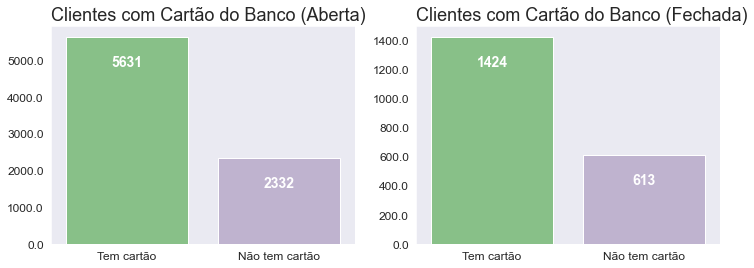

In [14]:
# grafico
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
ax = sns.countplot(churn_aberta.HasCrCard, order=churn_aberta.HasCrCard.value_counts().index)

ax.set_title('Clientes com Cartão do Banco (Aberta)', fontsize=18, loc='left');
ax.set_xlabel('', fontsize=14)
ax.set_ylabel('', fontsize=14)
ax.set_xticklabels(['Tem cartão', 'Não tem cartão'], fontsize=12);
ax.set_yticklabels(ax.get_yticks(), fontsize=12);

labels = (churn_aberta.HasCrCard.value_counts())
for i, v in enumerate(labels):
    ax.text(i, v-800, str(v), horizontalalignment = 'center', size = 14, color = 'w', fontweight = 'bold')

plt.subplot(1, 2, 2)
ax = sns.countplot(churn_fechada.HasCrCard, order=churn_fechada.HasCrCard.value_counts().index)

ax.set_title('Clientes com Cartão do Banco (Fechada)', fontsize=18, loc='left');
ax.set_xlabel('', fontsize=14)
ax.set_ylabel('', fontsize=14)
ax.set_xticklabels(['Tem cartão', 'Não tem cartão'], fontsize=12);
ax.set_yticklabels(ax.get_yticks(), fontsize=12);

labels = (churn_fechada.HasCrCard.value_counts())
for i, v in enumerate(labels):
    ax.text(i, v-200, str(v), horizontalalignment = 'center', size = 14, color = 'w', fontweight = 'bold')

Mas vendo o próximo gráfico, fica claro que a maioria dos clientes que fecharam suas contas não eram membros ativos do banco. 

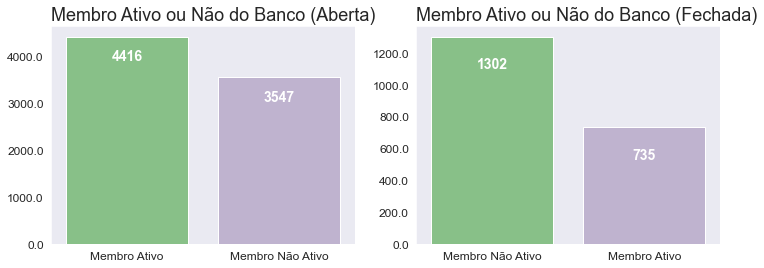

In [15]:
# grafico
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
ax = sns.countplot(churn_aberta.IsActiveMember, order=churn_aberta.IsActiveMember.value_counts().index)

ax.set_title('Membro Ativo ou Não do Banco (Aberta)', fontsize=18, loc='left');
ax.set_xlabel('', fontsize=14)
ax.set_ylabel('', fontsize=14)
ax.set_xticklabels(['Membro Ativo', 'Membro Não Ativo'], fontsize=12);
ax.set_yticklabels(ax.get_yticks(), fontsize=12);

labels = (churn_aberta.IsActiveMember.value_counts())
for i, v in enumerate(labels):
    ax.text(i, v-500, str(v), horizontalalignment = 'center', size = 14, color = 'w', fontweight = 'bold')

plt.subplot(1, 2, 2)
ax = sns.countplot(churn_fechada.IsActiveMember, order=churn_fechada.IsActiveMember.value_counts().index)

ax.set_title('Membro Ativo ou Não do Banco (Fechada)', fontsize=18, loc='left');
ax.set_xlabel('', fontsize=14)
ax.set_ylabel('', fontsize=14)
ax.set_xticklabels(['Membro Não Ativo', 'Membro Ativo'], fontsize=12);
ax.set_yticklabels(ax.get_yticks(), fontsize=12);

labels = (churn_fechada.IsActiveMember.value_counts())
for i, v in enumerate(labels):
    ax.text(i, v-200, str(v), horizontalalignment = 'center', size = 14, color = 'w', fontweight = 'bold')

## Preparando Dados e validação do Modelo

As primeiras colunas do dataset não devem ir para o modelo, elas são os números das linhas, os IDs e os sobrenomes.

Logo depois irei transformar os dados categóricos em numéricos.

In [16]:
# preparando dados para o modelo
X = churn.iloc[:, 3:-1]
y = churn.Exited

In [17]:
# tranforma variaveis categóricas em númericas
le = LabelEncoder()

X['Gender'] = le.fit_transform(X['Gender'])
X = pd.get_dummies(X)

X.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,0,0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0,1
2,502,0,42,8,159660.80,3,1,0,113931.57,1,0,0
3,699,0,39,1,0.00,2,0,0,93826.63,1,0,0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0,1


Aqui criei um dicionário para os modelos que irei utilizar.

In [18]:
models = dict()
models['gbc'] = GradientBoostingClassifier()
models['xgboost'] = XGBClassifier()
models['svm'] = SVC()
models['bayes'] = GaussianNB()

Aqui criei uma função para fazer a validação do modelo, utilizando validação cruzada.

In [19]:
def val_modelo(modelo, X, y):
    """
    Realiza cross-validation com os dados e os modelos.

    # Arguments
        modelo: Modelos para classificação.
        X: Dataframe com as váriaveis para classificação.
        y: Serie com a variavel alvo.

    # Returns
        float, média dos scores da cross-validation.
    """
    cvs = cross_val_score(modelo, X, y, cv=5)
    return cvs.mean()

Validação dos modelos separados

In [20]:
# teste dos modelos
resultados, nomes = list(), list()
for nome, modelo in models.items():
    scores = val_modelo(modelo, X, y)
    resultados.append(scores)
    nomes.append(nome)
    print(f'>{nome}, {scores:.3f}')

>gbc, 0.864
>xgboost, 0.858
>svm, 0.796
>bayes, 0.785


Stacking dos modelos utilizando como estimador final o XGBClassifier.

Fiz teste com o Gradient Boosting mas o XGBoost pareceu melhor.

In [21]:
estimators = [('gbc', GradientBoostingClassifier()),
              ('xgboost', XGBClassifier()),
              ('svm', SVC()),
              ('bayes', GaussianNB())]

# modelo de stacking
stacking = StackingClassifier(estimators=estimators, final_estimator=XGBClassifier(), cv=5)
stacking.fit(X, y)

StackingClassifier(cv=5,
                   estimators=[('gbc', GradientBoostingClassifier()),
                               ('xgboost',
                                XGBClassifier(base_score=None, booster=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None, gamma=None,
                                              gpu_id=None,
                                              importance_type='gain',
                                              interaction_constraints=None,
                                              learning_rate=None,
                                              max_delta_step=None,
                                              max_depth=None,
                                              min_child_weight=None,
                                              missi...
                                         

## Conclusão

Prevendo os dados para todo o dataset e comparando com os valores reais usanso o classification report, chegamos em uma precisão de 89% para a previsão se vão manter os clientes e 80% para clientes que irão fechar sua conta.

Utilizando o recall que seria, "quando realmente é da classe X, o quão frequente você classifica como X?". Nessa classificação ficamos com 97% para classificação de clientes que irão permanecer com suas contas, já os que fecharão a conta seria apenas 52%, não é tão ruim pois saber e poder recuperar metade dos clientes que sairão ajuda muito.

In [23]:
# previsão dos dados
y_pred = stacking.predict(X)

# classification report
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      7963
           1       0.80      0.52      0.63      2037

    accuracy                           0.88     10000
   macro avg       0.84      0.74      0.78     10000
weighted avg       0.87      0.88      0.87     10000



Com a matrix de confusão apenas confirmamos oque foi dito sobre o recall.

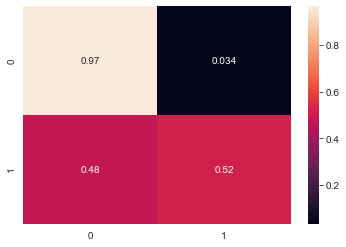

In [24]:
# matriz de confusão
cm = confusion_matrix(y, y_pred, normalize='true')

# mapa de calor com a matriz de confusão
sns.heatmap(cm, annot=True)